In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, average_precision_score
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, ADASYN, SVMSMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from collections import Counter

/Users/rlsma/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data

ds = pd.read_csv('TRN', sep='\t')

In [3]:
# Select columns

features = ds.columns.drop(['INDEX', 'IND_BOM_1_1', 'IND_BOM_1_2'])
X = ds[features]
y = ds['IND_BOM_1_1']

In [5]:
#  Selecting features usign RandomForest

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel = sel.fit(X,y)
X = sel.fit_transform(X,y)

In [6]:
# X = PCA(100).fit_transform(X)

In [7]:
# Converting X+y to Dataframe 

#  X = pd.DataFrame(data=X)
# y = pd.DataFrame(data=y)
# ds = pd.concat([X,y], axis=1)

# Generating heatmap of correlations

# import seaborn as sns
# import matplotlib.pyplot as plt

# corrmat = ds.corr()
# top_corr_features = corrmat.index
# plt.figure(figsize=(300,300))
# #plot heat map
# g=sns.heatmap(ds[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [8]:
# bestfeatures = SelectKBest(score_func=f_classif, k=50)
# X = bestfeatures.fit_transform(X, y)

In [9]:
# Separate data for train, validation and test
# Train: 1/2
# Validation: 1/4
# Test: 1/4

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, stratify=y, random_state=43)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=(2/3), stratify=y_train, random_state=44)

In [10]:
sm = ADASYN()
X_train, y_train = sm.fit_resample(X_train, y_train)

In [11]:
X_train, y_train = shuffle(X_train, y_train)

In [12]:
# Utility functions for testing models

# Accuracy: (TP + TN) / N
# Precision: TP / (TP + FP)
# Recall: TP / (TP + FN)
# F1-Measure: Harmonic average between Precision and Recall

def compute_metrics(pred, pred_probs, y, neg_class=0):
    cm = confusion_matrix(y_true=y, y_pred=pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp+tn) / (tp+tn+fp+fn)
    f_measure = f1_score(y, pred)
    
    pred_probs = np.array([v[0] if v[0] > v[1] else v[1] for v in pred_probs])
    roc_auc = roc_auc_score(y, pred_probs)
    pr_auc = average_precision_score(y, pred_probs)
    gd = generate_dist(pred_probs, np.array(y), neg_class)
    ks = ks_2samp(gd[0], gd[1])[0]
    return acc, precision, recall, f_measure, roc_auc, pr_auc, ks, cm

def report_performance_metrics(pred, pred_probs, _y, neg_class=0):
    acc, prec, rec, f_measure, roc_auc, pr_auc, ks, cm = compute_metrics(pred, pred_probs, _y, neg_class)
    skplt.metrics.plot_ks_statistic(_y, pred_probs)
    plt.show()
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F-Measure:', f_measure)
    print('AUROC:', roc_auc)
    print('AUPR:', pr_auc)
    print('Confusion Matrix:')
    print(cm)
    
def train_test_k_fold(k, clf, _X, _y, neg_class=0):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
    it = 1
    for train_index, test_index in skf.split(_X, _y):
        X_batch = _X[train_index]
        y_batch = _y[train_index]
        X_test_batch = _X[test_index]
        y_test_batch = _y[test_index]
        clf.fit(X_batch, y_batch)
        results = clf.predict(X_test_batch)
        results_probs = clf.predict_proba(X_test_batch)
        print('K Fold it', it)
        report_performance_metrics(results, results_probs, y_test_batch, neg_class)
        print('')
        it += 1
        
def test_model(clf, _X, _y):
    results = clf.predict(_X)
    results_probs = clf.predict_proba(_X)
    report_performance_metrics(results, results_probs, _y)
    
def generate_dist(probas, y, neg_class):
    dist_1 = [0] * 100
    dist_2 = [0] * 100
    for_perc = Counter(y)
    for i in range(1,101):
        limiar = i/100        
        lower = y[np.where(probas <= limiar)]
        count = Counter(lower)
        dist_1[i-1] = count[neg_class]
        dist_2[i-1] = count[1]
    return np.array(dist_1)/for_perc[neg_class], np.array(dist_2)/for_perc[1]

In [13]:
#_X_train = np.delete(X_train, cat_cols, 1)
#kk = np.delete(X_val, cat_cols, 1)

In [14]:
'''params = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [.0001, .01, 1, 10, 100],
    'gamma': [.0001, .001, .01, .1, 1, 10, 100],
}

clf = svm.SVC(decision_function_shape='ovo', verbose=True, max_iter=500)
grid = GridSearchCV(estimator=clf, param_grid=params)
search = grid.fit(X_train, y_train)
'''

"params = {\n    'kernel': ['rbf', 'linear', 'poly'],\n    'C': [.0001, .01, 1, 10, 100],\n    'gamma': [.0001, .001, .01, .1, 1, 10, 100],\n}\n\nclf = svm.SVC(decision_function_shape='ovo', verbose=True, max_iter=500)\ngrid = GridSearchCV(estimator=clf, param_grid=params)\nsearch = grid.fit(X_train, y_train)\n"

In [ ]:
#params = search.best_params_
#params

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 1


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


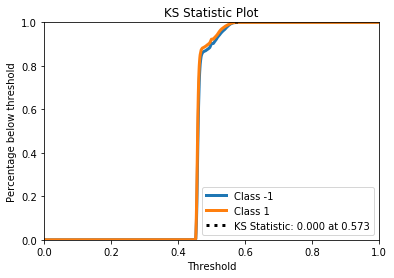

Accuracy: 0.4892557446474786
Precision: 0.45136887608069165
Recall: 0.09823598588788711
F-Measure: 0.16135470993496878
AUROC: 0.5588418480000229
AUPR: 0.5393389584828175
Confusion Matrix:
[[11224  1523]
 [11502  1253]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 2


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


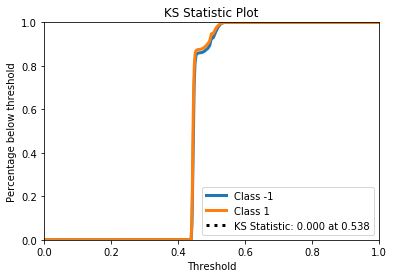

Accuracy: 0.48902046898282486
Precision: 0.45050215208034433
Recall: 0.09847118776950216
F-Measure: 0.1616161616161616
AUROC: 0.5653297443842482
AUPR: 0.5547019011051626
Confusion Matrix:
[[11215  1532]
 [11499  1256]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 3


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


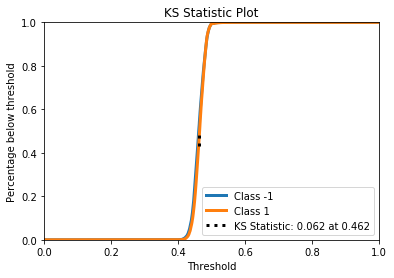

Accuracy: 0.5088820046272695
Precision: 0.5201676270298585
Recall: 0.23355546844374755
F-Measure: 0.3223677091223894
AUROC: 0.4658682629574013
AUPR: 0.46780470997085666
Confusion Matrix:
[[9998 2748]
 [9776 2979]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 4


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


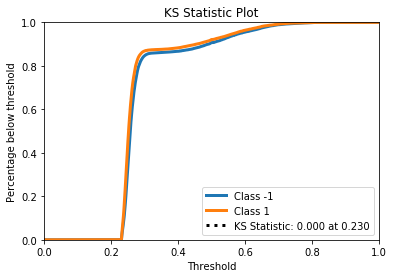

Accuracy: 0.4917846358966315
Precision: 0.46162485960314487
Recall: 0.09666797334378675
F-Measure: 0.15985997666277713
AUROC: 0.566582338527216
AUPR: 0.5523706865901324
Confusion Matrix:
[[11308  1438]
 [11522  1233]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 5


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


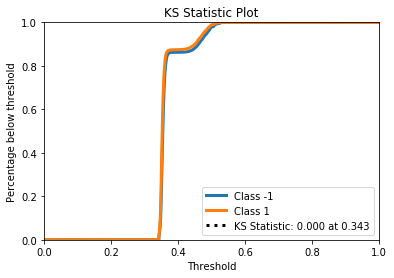

Accuracy: 0.4903729265518999
Precision: 0.39075249320036265
Recall: 0.0337906703253626
F-Measure: 0.06220233799971135
AUROC: 0.5727784976838107
AUPR: 0.5593665115077675
Confusion Matrix:
[[12074   672]
 [12324   431]]



/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


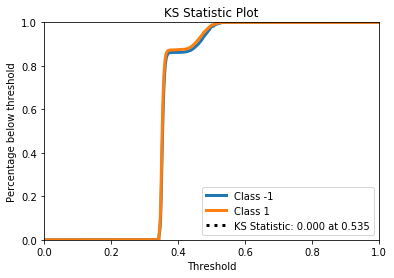

Accuracy: 0.34963360363415863
Precision: 0.5633658286300667
Recall: 0.034434095399379056
F-Measure: 0.0649012885683887
AUROC: 0.5553688646571611
AUPR: 0.6973837129816691
Confusion Matrix:
[[31823  1702]
 [61578  2196]]


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


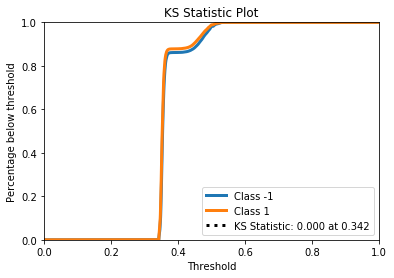

Accuracy: 0.3493252756965642
Precision: 0.5611264640084221
Recall: 0.033430289535786244
F-Measure: 0.06310119276644863
AUROC: 0.555505219927825
AUPR: 0.6960696302227896
Confusion Matrix:
[[ 63714   3335]
 [123285   4264]]


In [15]:
# Train SVM with k fold 

params = {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

svm_clf = svm.SVC(**params, decision_function_shape='ovo', 
              verbose=True, max_iter=200, probability=True)

_y_train = np.array([v if v == 1 else -1 for v in y_train])

train_test_k_fold(5, svm_clf, X_train, _y_train)

_y_val = np.array([v if v == 1 else -1 for v in y_val])
test_model(svm_clf, X_val, _y_val)

_y_test = np.array([v if v == 1 else -1 for v in y_test])
test_model(svm_clf, X_test, _y_test)

In [ ]:
# Run grid search to find best parameters
'''
    Best parameters found:
        Solver: adam
        hidden_layers: (12,12)
        learning_rate: 0.005
'''


'''solvers = ['lbfgs', 'adam',]
hidden_layers = [(12,12), (12,12,12), (5,5,5), (5,5)]
learning_rates = [.001, .0001, .005]

clf = MLPClassifier()
grid = GridSearchCV(estimator=clf, param_grid=dict(solver=solvers, hidden_layer_sizes=hidden_layers, learning_rate_init=learning_rates))
search = grid.fit(X_train, y_train)
'''

# parameters = {'solver': ['adam'], 'max_iter': [200,300,400,500,600,1000,2000], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
# grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)
# search = grid.fit(X_train, y_train)

In [16]:
# Rename best parameters found on grid search

# params = search.best_params_

params = {
    'solver': 'adam',
    'hidden_layer_sizes': (12,12),
    'learning_rate_init': .005,
    'max_iter': 500,
}

Iteration 1, loss = 0.65381057
Iteration 2, loss = 0.63719203
Iteration 3, loss = 0.63335880
Iteration 4, loss = 0.63133802
Iteration 5, loss = 0.62981986
Iteration 6, loss = 0.62800509
Iteration 7, loss = 0.62709857
Iteration 8, loss = 0.62522582
Iteration 9, loss = 0.62417304
Iteration 10, loss = 0.62357800
Iteration 11, loss = 0.62198724
Iteration 12, loss = 0.62178653
Iteration 13, loss = 0.62060342
Iteration 14, loss = 0.61999904
Iteration 15, loss = 0.61938123
Iteration 16, loss = 0.61911996
Iteration 17, loss = 0.61842998
Iteration 18, loss = 0.61799789
Iteration 19, loss = 0.61757981
Iteration 20, loss = 0.61695050
Iteration 21, loss = 0.61701574
Iteration 22, loss = 0.61595145
Iteration 23, loss = 0.61609442
Iteration 24, loss = 0.61578885
Iteration 25, loss = 0.61530261
Iteration 26, loss = 0.61517241
Iteration 27, loss = 0.61454857
Iteration 28, loss = 0.61480365
Iteration 29, loss = 0.61441807
Iteration 30, loss = 0.61433354
Iteration 31, loss = 0.61430624
Iteration 32, los

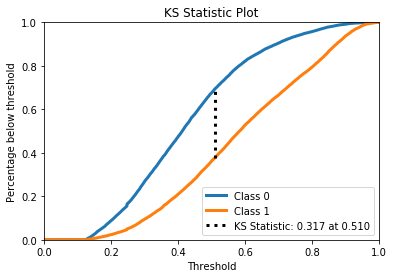

Accuracy: 0.6569288683240531
Precision: 0.6630310923001791
Recall: 0.6386515092120737
F-Measure: 0.6506129946887105
AUROC: 0.5494577105436174
AUPR: 0.5907755901528665
Confusion Matrix:
[[8607 4140]
 [4609 8146]]

Iteration 1, loss = 0.65527602
Iteration 2, loss = 0.63799518
Iteration 3, loss = 0.63415989
Iteration 4, loss = 0.63096365
Iteration 5, loss = 0.63018122
Iteration 6, loss = 0.62841192
Iteration 7, loss = 0.62756428
Iteration 8, loss = 0.62649324
Iteration 9, loss = 0.62581040
Iteration 10, loss = 0.62467977
Iteration 11, loss = 0.62389287
Iteration 12, loss = 0.62341154
Iteration 13, loss = 0.62266566
Iteration 14, loss = 0.62206953
Iteration 15, loss = 0.62130880
Iteration 16, loss = 0.62052149
Iteration 17, loss = 0.62009998
Iteration 18, loss = 0.61961272
Iteration 19, loss = 0.61879959
Iteration 20, loss = 0.61865737
Iteration 21, loss = 0.61799261
Iteration 22, loss = 0.61773134
Iteration 23, loss = 0.61728600
Iteration 24, loss = 0.61704134
Iteration 25, loss = 0.61686

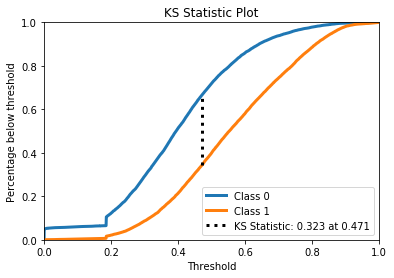

Accuracy: 0.6598698141322249
Precision: 0.6812006038540094
Recall: 0.6014112112896903
F-Measure: 0.6388241172551632
AUROC: 0.48702028012709553
AUPR: 0.4820294802968448
Confusion Matrix:
[[9157 3590]
 [5084 7671]]

Iteration 1, loss = 0.65572467
Iteration 2, loss = 0.63895609
Iteration 3, loss = 0.63489109
Iteration 4, loss = 0.63311429
Iteration 5, loss = 0.62994773
Iteration 6, loss = 0.62769461
Iteration 7, loss = 0.62504140
Iteration 8, loss = 0.62403220
Iteration 9, loss = 0.62300368
Iteration 10, loss = 0.62193819
Iteration 11, loss = 0.62101455
Iteration 12, loss = 0.62046280
Iteration 13, loss = 0.61965796
Iteration 14, loss = 0.62024695
Iteration 15, loss = 0.61875182
Iteration 16, loss = 0.61861795
Iteration 17, loss = 0.61751160
Iteration 18, loss = 0.61759533
Iteration 19, loss = 0.61731080
Iteration 20, loss = 0.61670877
Iteration 21, loss = 0.61666928
Iteration 22, loss = 0.61636875
Iteration 23, loss = 0.61562047
Iteration 24, loss = 0.61586120
Iteration 25, loss = 0.6149

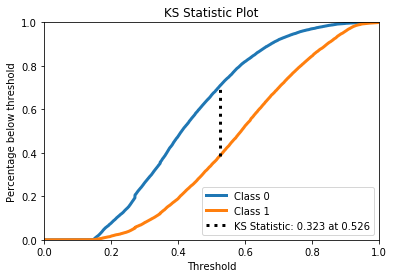

Accuracy: 0.6602878318497314
Precision: 0.6620465705686678
Recall: 0.6553508428067425
F-Measure: 0.6586816910287223
AUROC: 0.5294805088081376
AUPR: 0.5682009909104775
Confusion Matrix:
[[8479 4267]
 [4396 8359]]

Iteration 1, loss = 0.65355380
Iteration 2, loss = 0.63691280
Iteration 3, loss = 0.63322843
Iteration 4, loss = 0.63112376
Iteration 5, loss = 0.62804382
Iteration 6, loss = 0.62540549
Iteration 7, loss = 0.62429491
Iteration 8, loss = 0.62249600
Iteration 9, loss = 0.62143139
Iteration 10, loss = 0.62051208
Iteration 11, loss = 0.61998278
Iteration 12, loss = 0.61885875
Iteration 13, loss = 0.61820196
Iteration 14, loss = 0.61860882
Iteration 15, loss = 0.61817177
Iteration 16, loss = 0.61730872
Iteration 17, loss = 0.61686315
Iteration 18, loss = 0.61687773
Iteration 19, loss = 0.61636075
Iteration 20, loss = 0.61617554
Iteration 21, loss = 0.61546544
Iteration 22, loss = 0.61535392
Iteration 23, loss = 0.61498951
Iteration 24, loss = 0.61463936
Iteration 25, loss = 0.61420

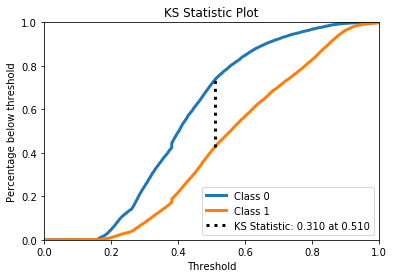

Accuracy: 0.6538959256499746
Precision: 0.6761093679964142
Recall: 0.591297530380243
F-Measure: 0.6308657465495608
AUROC: 0.5352532455282395
AUPR: 0.5849456187098354
Confusion Matrix:
[[9133 3613]
 [5213 7542]]

Iteration 1, loss = 0.65269197
Iteration 2, loss = 0.63769496
Iteration 3, loss = 0.63414531
Iteration 4, loss = 0.63222131
Iteration 5, loss = 0.63057066
Iteration 6, loss = 0.62915417
Iteration 7, loss = 0.62741022
Iteration 8, loss = 0.62583352
Iteration 9, loss = 0.62421713
Iteration 10, loss = 0.62337217
Iteration 11, loss = 0.62249392
Iteration 12, loss = 0.62128347
Iteration 13, loss = 0.62058976
Iteration 14, loss = 0.61898193
Iteration 15, loss = 0.61832659
Iteration 16, loss = 0.61824570
Iteration 17, loss = 0.61716694
Iteration 18, loss = 0.61603887
Iteration 19, loss = 0.61555641
Iteration 20, loss = 0.61484792
Iteration 21, loss = 0.61385704
Iteration 22, loss = 0.61351204
Iteration 23, loss = 0.61307949
Iteration 24, loss = 0.61255503
Iteration 25, loss = 0.612804

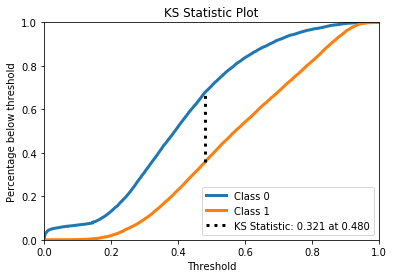

Accuracy: 0.6587584800596055
Precision: 0.6759878419452887
Recall: 0.6102704821638573
F-Measure: 0.6414503502266172
AUROC: 0.5101941052151671
AUPR: 0.4989626571514638
Confusion Matrix:
[[9015 3731]
 [4971 7784]]



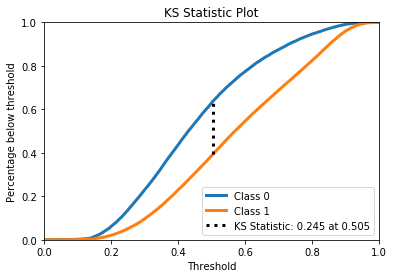

Accuracy: 0.6190505555041675
Precision: 0.7589992242048099
Recall: 0.6136356508922132
F-Measure: 0.6786203547956371
AUROC: 0.538912911311282
AUPR: 0.709024078539649
Confusion Matrix:
[[21099 12426]
 [24640 39134]]


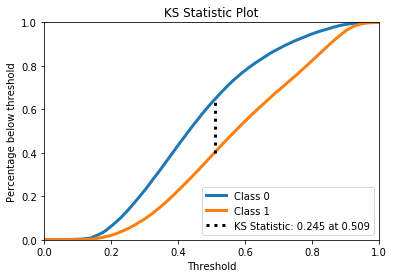

Accuracy: 0.6194462430240805
Precision: 0.7591763565891473
Recall: 0.614250209723322
F-Measure: 0.6790668648618196
AUROC: 0.5414393810340182
AUPR: 0.7098477608050531
Confusion Matrix:
[[42196 24853]
 [49202 78347]]


In [17]:
# Train MLP with best parameters found on grid search
mlp = MLPClassifier(**params, alpha=1e-4, verbose=True, activation='relu', batch_size=128, tol=1e-7, random_state=9)

# Uncomment below line to run k fold on the MLP
train_test_k_fold(5, mlp, X_train, y_train)

test_model(mlp, X_val, y_val)

test_model(mlp, X_test, y_test)

In [ ]:
# Train Keras MLP

'''input_dims = X_train.shape

model = Sequential()
model.add(Dense(1, input_dim=input_dims[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_val, y_val = np.array(X_val), np.array(y_val)

history = model.fit(X_train, y_train, epochs=2, shuffle=True, batch_size=128, validation_data=(X_val, y_val))
'''

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 1


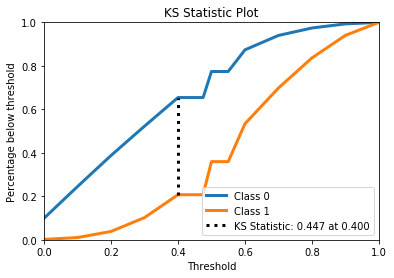

Accuracy: 0.7071994353384048
Precision: 0.7392327180600796
Recall: 0.6405331242649941
F-Measure: 0.6863527533918595
AUROC: 0.4339104239467634
AUPR: 0.4581685868925761
Confusion Matrix:
[[9865 2882]
 [4585 8170]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 2


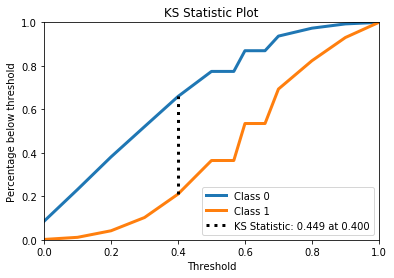

Accuracy: 0.7048466786918673
Precision: 0.7380692167577414
Recall: 0.635358682869463
F-Measure: 0.682873393722351
AUROC: 0.4408520961742653
AUPR: 0.465976908289193
Confusion Matrix:
[[9871 2876]
 [4651 8104]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 3


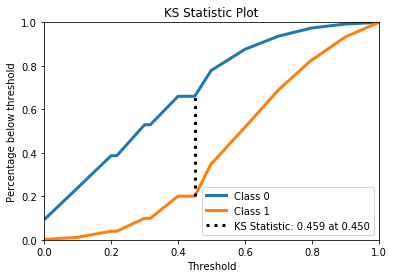

Accuracy: 0.7142857142857143
Precision: 0.7473988962272686
Recall: 0.6476675813406507
F-Measure: 0.6939684139784946
AUROC: 0.44130902967198626
AUPR: 0.4635527352747799
Confusion Matrix:
[[9954 2792]
 [4494 8261]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 4


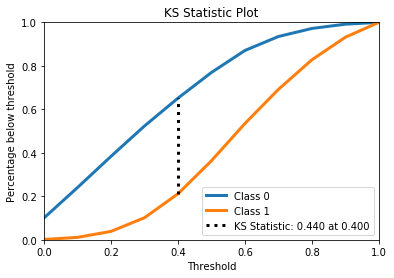

Accuracy: 0.7029528253793969
Precision: 0.7343467245747376
Recall: 0.6362994903959232
F-Measure: 0.6818162725248877
AUROC: 0.43603701498684644
AUPR: 0.4607531014707103
Confusion Matrix:
[[9810 2936]
 [4639 8116]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 5


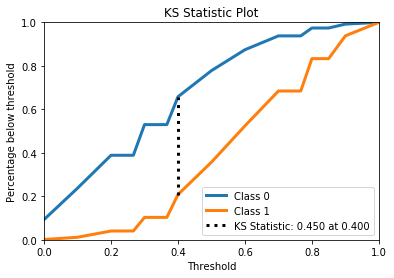

Accuracy: 0.7104427277361672
Precision: 0.7434944237918215
Recall: 0.6428851430811446
F-Measure: 0.6895391860073999
AUROC: 0.4401459588893093
AUPR: 0.4621379646237261
Confusion Matrix:
[[9917 2829]
 [4555 8200]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


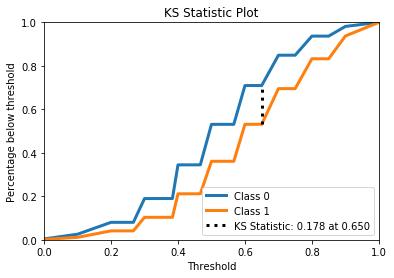

Accuracy: 0.6017636358030402
Precision: 0.7215631418655712
Recall: 0.6389908113024116
F-Measure: 0.6777713097713098
AUROC: 0.5699618495747486
AUPR: 0.7088403187579756
Confusion Matrix:
[[17800 15725]
 [23023 40751]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


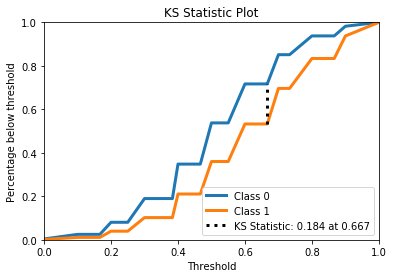

Accuracy: 0.6047133064060268
Precision: 0.7247392018466728
Recall: 0.6399971775552925
F-Measure: 0.6797372014788662
AUROC: 0.5718189282723856
AUPR: 0.7098987171136961
Confusion Matrix:
[[36045 31004]
 [45918 81631]]


In [18]:
rn = RandomForestClassifier(verbose=True, max_depth=50)

train_test_k_fold(5, rn, X_train, y_train)

test_model(rn, X_val, y_val)

test_model(rn, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 1


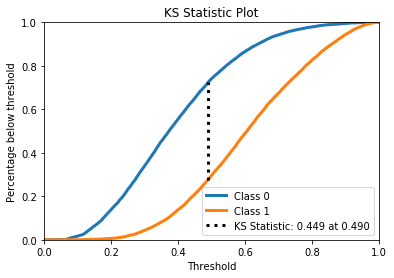

Accuracy: 0.722257077876245
Precision: 0.7308318411199739
Recall: 0.7039592316738534
F-Measure: 0.7171438840301904
AUROC: 0.4848616243076018
AUPR: 0.5255074418241739
Confusion Matrix:
[[9440 3307]
 [3776 8979]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 2


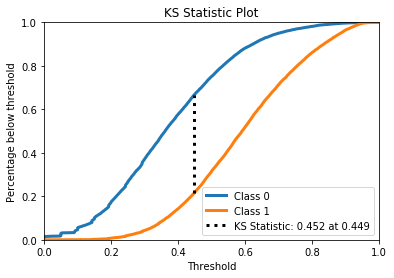

Accuracy: 0.7184534546310093
Precision: 0.7337134233252285
Recall: 0.6860838886711094
F-Measure: 0.7090997488047971
AUROC: 0.444093513429052
AUPR: 0.45781702914178146
Confusion Matrix:
[[9571 3176]
 [4004 8751]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 3


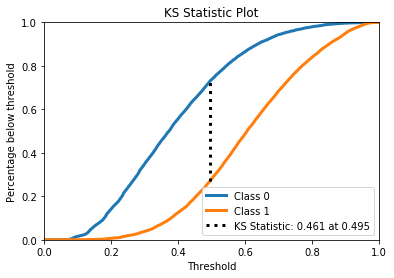

Accuracy: 0.7291870907023253
Precision: 0.7326386126799778
Recall: 0.7220697765582125
F-Measure: 0.7273158019426675
AUROC: 0.4736711767223088
AUPR: 0.5159656743037618
Confusion Matrix:
[[9385 3361]
 [3545 9210]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 4


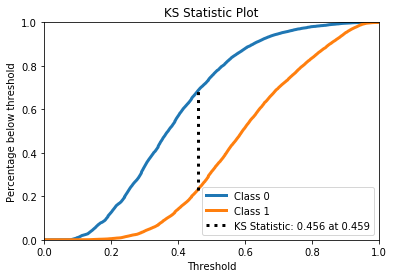

Accuracy: 0.7195796243284577
Precision: 0.7349882589734988
Recall: 0.6871030968247746
F-Measure: 0.7102394748571659
AUROC: 0.4720618663741088
AUPR: 0.5221333147613276
Confusion Matrix:
[[9586 3160]
 [3991 8764]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 5


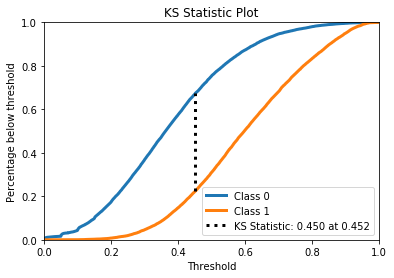

Accuracy: 0.7217364024940198
Precision: 0.7365604882534905
Recall: 0.6907095256762054
F-Measure: 0.7128985272697848
AUROC: 0.4605928559965746
AUPR: 0.47401458545979247
Confusion Matrix:
[[9595 3151]
 [3945 8810]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


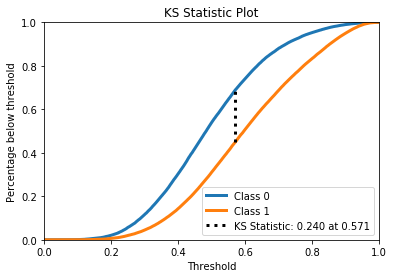

Accuracy: 0.6379716132745454
Precision: 0.7399035310330919
Recall: 0.6903283469752564
F-Measure: 0.7142567430541472
AUROC: 0.5734123516471417
AUPR: 0.7355474433566204
Confusion Matrix:
[[18049 15476]
 [19749 44025]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


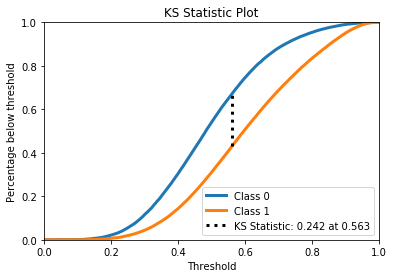

Accuracy: 0.6385060483663758
Precision: 0.7406986627618303
Recall: 0.690048530368721
F-Measure: 0.714477059453843
AUROC: 0.5760292877175403
AUPR: 0.7372213767902086
Confusion Matrix:
[[36237 30812]
 [39534 88015]]


In [19]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf = VotingClassifier(estimators=[('rn', rn), ('mlp', mlp)], voting='soft', n_jobs=-1)

train_test_k_fold(5, eclf, X_train, y_train)

test_model(eclf, X_val, y_val)

test_model(eclf, X_test, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  7.9min remaining:  7.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


K Fold it 1


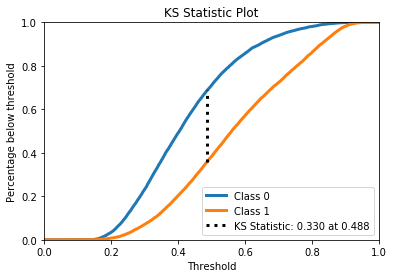

Accuracy: 0.6630068229942749
Precision: 0.6797408207343413
Recall: 0.6168561348490788
F-Measure: 0.6467735306206329
AUROC: 0.5272365359592839
AUPR: 0.5793743188992305
Confusion Matrix:
[[9040 3707]
 [4887 7868]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.2min remaining:  8.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 12.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished


K Fold it 2


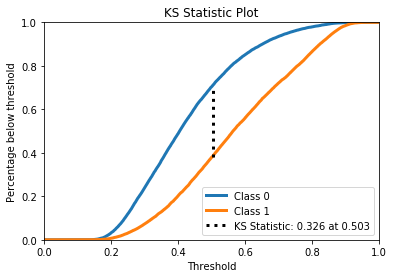

Accuracy: 0.6624186338326405
Precision: 0.6770281810418446
Recall: 0.6215601724813798
F-Measure: 0.6481095442468833
AUROC: 0.5293438134435333
AUPR: 0.5780727467333556
Confusion Matrix:
[[8965 3782]
 [4827 7928]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.2min remaining:  8.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished


K Fold it 3


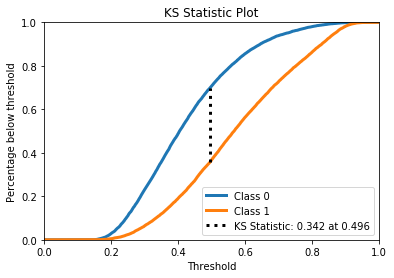

Accuracy: 0.6701697972628524
Precision: 0.6838496698831894
Recall: 0.6333986671893375
F-Measure: 0.6576580243396148
AUROC: 0.5243214479844193
AUPR: 0.5769362609192039
Confusion Matrix:
[[9011 3735]
 [4676 8079]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.9min remaining:  8.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished


K Fold it 4


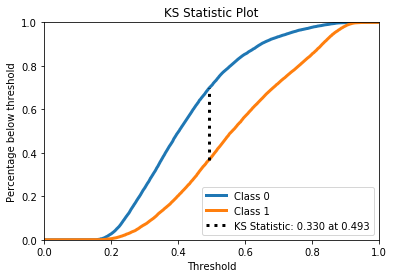

Accuracy: 0.664052390102349
Precision: 0.6804550155118925
Recall: 0.6190513524108193
F-Measure: 0.6483024754710784
AUROC: 0.5270229111777974
AUPR: 0.5811446815712696
Confusion Matrix:
[[9038 3708]
 [4859 7896]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 10.0min remaining: 10.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 11.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished


K Fold it 5


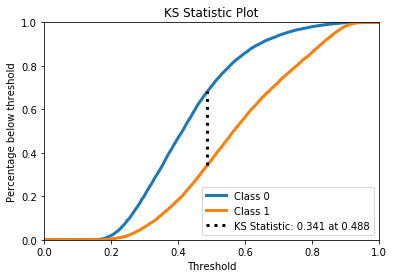

Accuracy: 0.6694247284420218
Precision: 0.6827825204969994
Recall: 0.6333202665621325
F-Measure: 0.6571219393150574
AUROC: 0.53568739838166
AUPR: 0.5863879322840408
Confusion Matrix:
[[8993 3753]
 [4677 8078]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.8s finished


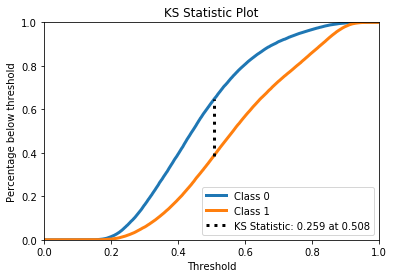

Accuracy: 0.628927327105109
Precision: 0.7638510098602025
Recall: 0.6280145513845767
F-Measure: 0.6893044308862633
AUROC: 0.5454661491419166
AUPR: 0.7223459557430367
Confusion Matrix:
[[21143 12382]
 [23723 40051]]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.4s remaining:    7.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.3s finished


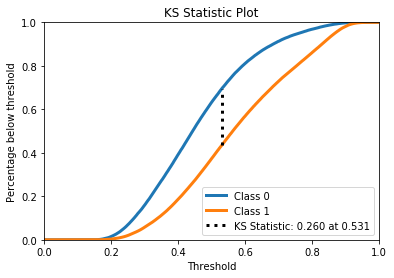

Accuracy: 0.6285727499768754
Precision: 0.764020254132034
Recall: 0.6269747312797435
F-Measure: 0.6887463988734771
AUROC: 0.5483478835718292
AUPR: 0.724222990919044
Confusion Matrix:
[[42349 24700]
 [47579 79970]]


In [20]:
mlp_ensemble = BaggingClassifier(base_estimator=mlp, n_jobs=-1, verbose=True)

train_test_k_fold(5, mlp_ensemble, X_train, y_train)

test_model(mlp_ensemble, X_val, y_val)

test_model(mlp_ensemble, X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.2405           28.17m
         2           1.1172           28.51m
         3           1.0083           32.09m
         4           0.9125           31.32m
         5           0.8281           28.63m
         6           0.7558           24.09m
         7           0.6895           18.90m
         8           0.6318           13.06m
         9           0.5811            6.71m
        10           0.5348            0.00s
K Fold it 1


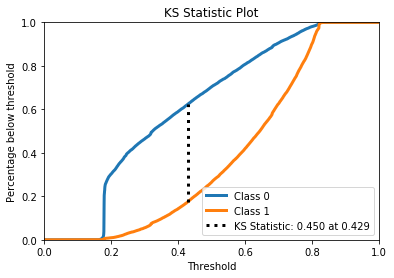

Accuracy: 0.7193945572896243
Precision: 0.7126794803616197
Recall: 0.7354762838102705
F-Measure: 0.7238984489543947
AUROC: 0.3898504246792898
AUPR: 0.4104903867776057
Confusion Matrix:
[[8965 3782]
 [3374 9381]]

      Iter       Train Loss   Remaining Time 
         1           1.2440           26.69m
         2           1.1227           26.96m
         3           1.0139           30.14m
         4           0.9181           29.42m
         5           0.8374           26.36m
         6           0.7638           22.39m
         7           0.7001           17.45m
         8           0.6409           12.12m
         9           0.5867            6.33m
        10           0.5389            0.00s
K Fold it 2


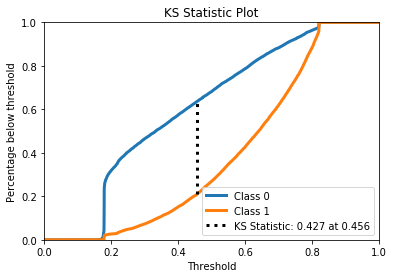

Accuracy: 0.7062191200690142
Precision: 0.6965125830781869
Recall: 0.7312426499411996
F-Measure: 0.7134552130344987
AUROC: 0.3914522158571557
AUPR: 0.4133888105759861
Confusion Matrix:
[[8683 4064]
 [3428 9327]]

      Iter       Train Loss   Remaining Time 
         1           1.2426           27.77m
         2           1.1221           27.75m
         3           1.0166           27.15m
         4           0.9264           25.08m
         5           0.8415           24.47m
         6           0.7652           21.65m
         7           0.6985           17.48m
         8           0.6392           12.25m
         9           0.5867            6.38m
        10           0.5391            0.00s
K Fold it 3


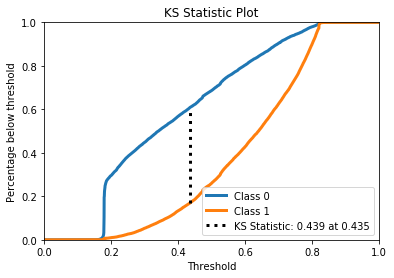

Accuracy: 0.7132269322771656
Precision: 0.7023048327137547
Recall: 0.7405723245785967
F-Measure: 0.7209311200152643
AUROC: 0.39793383346282213
AUPR: 0.4146143952533265
Confusion Matrix:
[[8742 4004]
 [3309 9446]]

      Iter       Train Loss   Remaining Time 
         1           1.2411           27.76m
         2           1.1135           34.54m
         3           1.0102           33.26m
         4           0.9128           31.58m
         5           0.8312           28.69m
         6           0.7554           24.96m
         7           0.6905           19.64m
         8           0.6335           13.54m
         9           0.5829            6.95m
        10           0.5360            0.00s
K Fold it 4


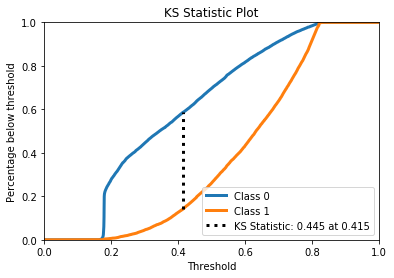

Accuracy: 0.717854201796008
Precision: 0.7090225563909774
Recall: 0.7393179145433163
F-Measure: 0.7238533870658223
AUROC: 0.3959374776834085
AUPR: 0.4113557393999019
Confusion Matrix:
[[8876 3870]
 [3325 9430]]

      Iter       Train Loss   Remaining Time 
         1           1.2423           27.89m
         2           1.1189           30.41m
         3           1.0084           32.59m
         4           0.9112           31.23m
         5           0.8291           27.83m
         6           0.7546           23.42m
         7           0.6883           18.35m
         8           0.6323           12.59m
         9           0.5785            6.51m
        10           0.5296            0.00s
K Fold it 5


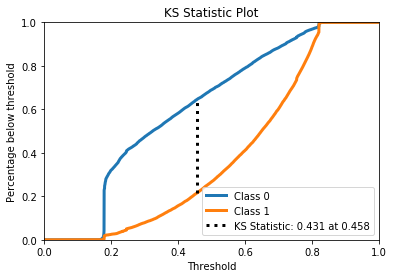

Accuracy: 0.7113838672993216
Precision: 0.7025606367800555
Recall: 0.733516268130145
F-Measure: 0.7177048174286591
AUROC: 0.3987553731278744
AUPR: 0.41922171841223405
Confusion Matrix:
[[8785 3961]
 [3399 9356]]



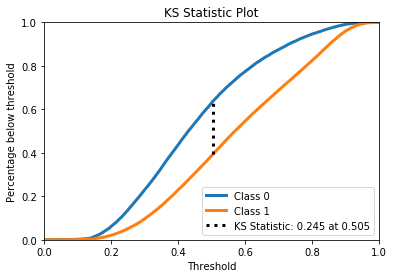

Accuracy: 0.6190505555041675
Precision: 0.7589992242048099
Recall: 0.6136356508922132
F-Measure: 0.6786203547956371
AUROC: 0.538912911311282
AUPR: 0.709024078539649
Confusion Matrix:
[[21099 12426]
 [24640 39134]]


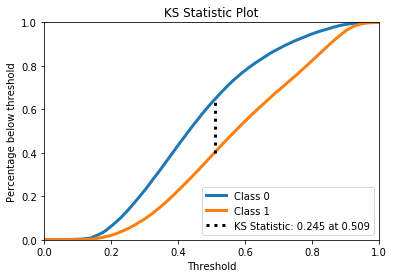

Accuracy: 0.6194462430240805
Precision: 0.7591763565891473
Recall: 0.614250209723322
F-Measure: 0.6790668648618196
AUROC: 0.5414393810340182
AUPR: 0.7098477608050531
Confusion Matrix:
[[42196 24853]
 [49202 78347]]


In [21]:
grad_boosting_clf = GradientBoostingClassifier(n_estimators=10, max_depth=20, verbose=True)
train_test_k_fold(5, grad_boosting_clf, X_train, y_train)

test_model(mlp, X_val, y_val)

test_model(mlp, X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf = VotingClassifier(estimators=[('rn', rn), ('mlp', mlp),], voting='soft', n_jobs=-1)

train_test_k_fold(5, eclf, X_train, y_train)

test_model(eclf, X_val, y_val)

test_model(eclf, X_test, y_test)